# TOWARDS A CLEAR UNDERSTANDING OF RURAL INTERNET: WHAT STATISTICAL MEASURES CAN BE USED TO ASSESS, COMPARE AND FORECAST INTERNET SPEEDS FOR RURAL CANADIAN COMMUNITIES?

The Government of Canada has committed to helping 95% of Canadian households and businesses access high-speed internet at minimum speeds of 50 Mbps download and 10 Mbps upload (hereinafter referred to as the “Commitment”) by 2026, and 100% by 2030. According to the CRTC, currently 45.6% of rural community households have access to the Commitment based on what’s available to them via an Internet Service Provider (e.g. Shaw, Telus, etc.) in their region, rather than what a rural household actually realizes at home in terms of internet speeds. 

https://ssc.ca/en/case-study/towards-a-clear-understanding-rural-internet-what-statistical-measures-can-be-used-assess

## Import libraried and read data

In [3]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
colab_dir = '/content/gdrive/My Drive/Colab_files/2022_CCS_case_study'
sys.path.append(colab_dir)

Mounted at /content/gdrive


In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.vector_ar.var_model import VAR

In [23]:
%matplotlib inline
import tqdm
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
plt.style.use('seaborn')
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error,r2_score
from statsmodels.tsa.arima.model import ARIMA 
import statsmodels.api as sm

In [6]:
df = pd.read_csv(colab_dir+'/canada_aggregation_CD_SACTYPE_isrural_conn_type_imputed_step3.csv')
train = pd.read_csv(colab_dir+'/canada_test_imp.csv')
display(train.head(2))
valid = pd.read_csv(colab_dir+'/canada_valid_imp.csv')
display(valid.head(2))
print(train.shape, valid.shape)

,date,PRUID,CDUID,SACTYPE,is_rural,conn_type,avg_d_mbps_wt,avg_u_mbps_wt,avg_lat_ms,tests,DA_POP,imputed
0,2019-01-01,10,1001,1,False,fixed,110.345156,72.589665,10.505591,6618,550285.0,False
1,2019-01-01,10,1001,1,False,mobile,92.795777,28.836200,65.107692,130,43085.0,False


,date,PRUID,CDUID,SACTYPE,is_rural,conn_type,avg_d_mbps_wt,avg_u_mbps_wt,avg_lat_ms,tests,DA_POP,imputed
0,2021-10-01,10,1001,1,False,fixed,206.369578,102.525161,11.942926,9584,640785.0,False
1,2021-10-01,10,1001,1,False,mobile,140.187612,24.954678,38.949468,376,111080.0,False


(30481, 12) (2771, 12)


# Make a prediction for all Census devision

In [7]:
n_models = train.groupby(['PRUID','CDUID','SACTYPE', 'is_rural','conn_type']).size().reset_index().rename(columns={0:'count'})
print(n_models.shape)
print(n_models['count'].value_counts())
n_models.head(2)

(2771, 6)
11    2771
Name: count, dtype: int64


,PRUID,CDUID,SACTYPE,is_rural,conn_type,count
0,10,1001,1,False,fixed,11
1,10,1001,1,False,mobile,11


In [ ]:
RMSE_scores={}

In [38]:
#specify minimum or maximum possible values in a forecast
def f(x, a, b):
  x = np.array(x)
  return np.log((x-a)/(b-x))

def finv(x, a, b):
  x = np.array(x)
  return (b * np.exp(x) + a) / (np.exp(x) + 1)

x = [12, 14, 15]
MAX_D = 2000 # 2,000 Mb
MAX_U = 1000
finv(f(x, min(x)-(10e-3), MAX_D), min(x)-(10e-3), MAX_D)

array([12., 14., 15.])

In [51]:
#Baseline
baseline = df[df.date == '2021-07-01']
baseline.shape

mse_d = mean_squared_error(valid["avg_d_mbps_wt"],baseline['avg_d_mbps_wt'])
mse_u = mean_squared_error(valid["avg_u_mbps_wt"],baseline['avg_u_mbps_wt'])

print("Root Mean Square Error for ARIMA Model for download speed: ",np.sqrt(mse_d))
print("Root Mean Square Error for  Model for upload speed: ",np.sqrt(mse_u))

print("Mean Square Error for ARIMA Model for download speed: ",mse_d)
print("Mean Square Error for ARIMA Model for upload speed: ",mse_u)

baseline.to_csv(colab_dir+'/pred_baseline.csv', index=False)

Root Mean Square Error for ARIMA Model for download speed:  43.484461503462626
Root Mean Square Error for  Model for upload speed:  18.25824112371778
Mean Square Error for ARIMA Model for download speed:  1890.8983922461232
Mean Square Error for ARIMA Model for upload speed:  333.3633689318192


## Vector Autoregression
source: https://www.statsmodels.org/dev/vector_ar.html

details: https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/

In [ ]:
from statsmodels.tsa.stattools import adfuller
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

0it [00:00, ?it/s]


 > Is the 12 lag differenced data stationary ?
Test statistic = 0.933
P-value = 0.994
Critical values :
	1%: -4.473135048010974 - The data is not stationary with 99% confidence
	5%: -3.28988060356653 - The data is not stationary with 95% confidence
	10%: -2.7723823456790124 - The data is not stationary with 90% confidence


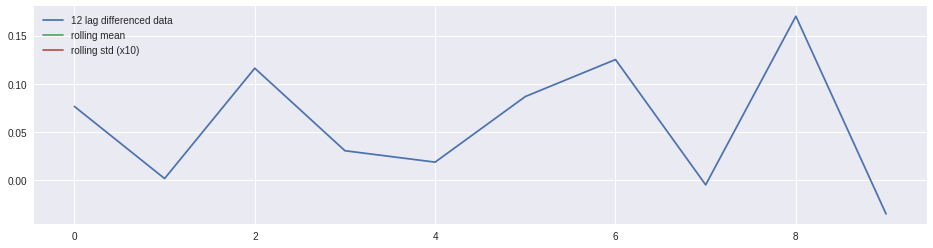

In [ ]:
for index, m in tqdm.tqdm(n_models.iterrows()):
  colnames = ['CDUID', 'SACTYPE', 'is_rural', 'conn_type']
  m_train = train[train[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt']]
  m_valid = valid[valid[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt']]
  y =  np.log(m_train.iloc[:,0])
  y_12lag = np.diff(y) #y.diff(periods=1))
  test_stationarity(y_12lag,'12 lag differenced data')
  ADF_test(y,'12 lag differenced data')
  #model = VAR(endog=train[['avg_d_mbps_wt', 'avg_u_mbps_wt']])
  #model_fit = model.fit()
  break #40 sec

In [ ]:
#fit the model
model = VAR(endog=train)
model_fit = model.fit()
# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

## AR Model (using AUTO ARIMA) without covariates
source: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
* p: number of autoregressive terms (AR order)
* d: number of nonseasonal differences (differencing order)
* q: number of moving-average terms (MA order)

In [ ]:
pred = n_models.copy()
pred['avg_d_valid']=0
pred['avg_d_pred']=0
pred['avg_u_valid']=0
pred['avg_u_pred']=0
print(pred.shape)

# AR Model ARIMA(order=(4, 1, 0) order = (1, 1, 3)
for index, m in tqdm.tqdm(pred.iterrows()):
  colnames = ['CDUID', 'SACTYPE', 'is_rural', 'conn_type']
  m_train = train[train[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt']]
  m_valid = valid[valid[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt']]
  #display(m_valid)
  y_d =  m_train.iloc[:,0]
  y_u =  m_train.iloc[:,1]

  model_ar = auto_arima(y_d,trace=True, error_action='ignore', start_p=0,start_q=0,max_p=2,max_q=2,
                   suppress_warnings=True,stepwise=False,seasonal=False, verbose = False)
  model_ar.fit(y_d)
  d = model_ar.predict(n_periods=1)[0]
  
  model_ar.fit(y_u)
  u = model_ar.predict(n_periods=1)[0]
  pred.iloc[index, 6:10] = [m_valid.iloc[0,0],d,m_valid.iloc[0,1], u]
  #break #40 sec


In [ ]:
pred.to_csv(colab_dir+'/pred_AR.csv', index=False)
pred.head(2)

,PRUID,CDUID,SACTYPE,is_rural,conn_type,count,avg_d_valid,avg_d_pred,avg_u_valid,avg_u_pred
0,10,1001,1,False,fixed,11,206.369578,219.075558,102.525161,101.466994
1,10,1001,1,False,mobile,11,140.187612,147.105203,24.954678,25.091812


In [ ]:
pred = pd.read_csv(colab_dir+'/pred_AR.csv')

In [ ]:
RMSE_scores['AR'] = [np.sqrt(mean_squared_error(pred["avg_d_valid"],pred['avg_d_pred'])),
                     np.sqrt(mean_squared_error(pred["avg_u_valid"],pred['avg_u_pred']))]


print("Root Mean Square Error for AR Model for download speed: ",np.sqrt(mean_squared_error(pred["avg_d_valid"],pred['avg_d_pred'])))
print("Root Mean Square Error for AR Model for upload speed: ",np.sqrt(mean_squared_error(pred["avg_u_valid"],pred['avg_u_pred'])))

print("Mean Square Error for AR Model for download speed: ",mean_squared_error(pred["avg_d_valid"],pred['avg_d_pred']))
print("Mean Square Error for AR Model for upload speed: ",mean_squared_error(pred["avg_u_valid"],pred['avg_u_pred']))

Root Mean Square Error for AR Model for download speed:  44.448486273238665
Root Mean Square Error for AR Model for upload speed:  19.902644125878524
Mean Square Error for AR Model for download speed:  1975.667931982286
Mean Square Error for AR Model for upload speed:  396.11524320136687


## ARIMA Model (using AUTOARIMA) without covariates

In [ ]:
pred_arima = n_models.copy()
pred_arima['avg_d_valid']=0
pred_arima['avg_d_pred']=0
pred_arima['avg_u_valid']=0
pred_arima['avg_u_pred']=0

for index, m in tqdm.tqdm(pred_arima.iterrows()):
  colnames = ['CDUID', 'SACTYPE', 'is_rural', 'conn_type']
  m_train = train[train[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt']]
  m_valid = valid[valid[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt']]
  
  y_d =  m_train.iloc[:,0]
  y_u =  m_train.iloc[:,1]

  model_ar = auto_arima(y_d,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False, verbose = False)
  model_ar.fit(y_d)
  d = model_ar.predict(n_periods=1)[0]
  
  model_ar.fit(y_u)
  u = model_ar.predict(n_periods=1)[0]
  pred_arima.iloc[index, 6:10] = [m_valid.iloc[0,0],d,m_valid.iloc[0,1], u]

pred_arima.to_csv(colab_dir+'/pred_ARIMA.csv', index=False)

In [ ]:
pred_arima = pd.read_csv(colab_dir+'/pred_ARIMA.csv')
pred_arima.head(2)

,PRUID,CDUID,SACTYPE,is_rural,conn_type,count,avg_d_valid,avg_d_pred,avg_u_valid,avg_u_pred
0,10,1001,1,False,fixed,11,206.369578,219.075558,102.525161,101.466994
1,10,1001,1,False,mobile,11,140.187612,147.105203,24.954678,25.091812


In [ ]:
RMSE_scores['ARIMA'] = [np.sqrt(mean_squared_error(pred_arima["avg_d_valid"],pred_arima['avg_d_pred'])),
                     np.sqrt(mean_squared_error(pred_arima["avg_u_valid"],pred_arima['avg_u_pred']))]


print("Root Mean Square Error for ARIMA Model for download speed: ",np.sqrt(mean_squared_error(pred_arima["avg_d_valid"],pred_arima['avg_d_pred'])))
print("Root Mean Square Error for  Model for upload speed: ",np.sqrt(mean_squared_error(pred_arima["avg_u_valid"],pred_arima['avg_u_pred'])))

print("Mean Square Error for ARIMA Model for download speed: ",mean_squared_error(pred_arima["avg_d_valid"],pred_arima['avg_d_pred']))
print("Mean Square Error for ARIMA Model for upload speed: ",mean_squared_error(pred_arima["avg_u_valid"],pred_arima['avg_u_pred']))

Root Mean Square Error for ARIMA Model for download speed:  44.35681342800491
Root Mean Square Error for  Model for upload speed:  19.748978518708693
Mean Square Error for ARIMA Model for download speed:  1967.5268974868368
Mean Square Error for ARIMA Model for upload speed:  390.02215253241735


## fixed ARIMA Model without covariates

In [ ]:
pred_arima_sw = n_models.copy()
pred_arima_sw['avg_d_valid']=0
pred_arima_sw['avg_d_pred']=0
pred_arima_sw['avg_u_valid']=0
pred_arima_sw['avg_u_pred']=0

for index, m in tqdm.tqdm(pred_arima_sw.iterrows()):
  colnames = ['CDUID', 'SACTYPE', 'is_rural', 'conn_type']
  m_train = train[train[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt']]
  m_valid = valid[valid[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt']]
  #display(m_valid)
  y_d =  m_train.iloc[:,0]
  y_u =  m_train.iloc[:,1]

  arima = sm.tsa.arima.ARIMA(y_d, order=(1, 0, 0)).fit()
  #sarima = sm.tsa.statespace.SARIMAX(y_d, trend='c', order=(1,1,1)).fit()
  d = arima.forecast(1)
  arima = sm.tsa.arima.ARIMA(y_u, order=(1, 0, 0)).fit()
  u = arima.forecast(1)

  pred_arima_sw.iloc[index, 6:10] = [m_valid.iloc[0,0],d,m_valid.iloc[0,1], u]
  #break
#pred_arima_sw.to_csv(colab_dir+'/pred_ARIMA_sw.csv', index=False)

mse_d = mean_squared_error(pred_arima_sw["avg_d_valid"],pred_arima_sw['avg_d_pred'])
mse_u = mean_squared_error(pred_arima_sw["avg_u_valid"],pred_arima_sw['avg_u_pred'])
#RMSE_scores['ARIMA_s'] = [np.sqrt(mse_d), np.sqrt(mse_u)]

print("Root Mean Square Error for ARIMA Model for download speed: ",np.sqrt(mse_d))
print("Root Mean Square Error for  Model for upload speed: ",np.sqrt(mse_u))

print("Mean Square Error for ARIMA Model for download speed: ",mse_d)
print("Mean Square Error for ARIMA Model for upload speed: ",mse_u)

2771it [03:22, 13.67it/s]

Root Mean Square Error for ARIMA Model for download speed:  42.331132540068836
Root Mean Square Error for  Model for upload speed:  18.430700108342897
Mean Square Error for ARIMA Model for download speed:  1791.9247821248746
Mean Square Error for ARIMA Model for upload speed:  339.6907064836709


In [ ]:
from statsmodels.tsa.arima.model import ARIMA 

pred_arima_sw = n_models.copy()
pred_arima_sw['avg_d_valid']=0
pred_arima_sw['avg_d_pred']=0
pred_arima_sw['avg_u_valid']=0
pred_arima_sw['avg_u_pred']=0

for index, m in tqdm.tqdm(pred_arima_sw.iterrows()):
  colnames = ['CDUID', 'SACTYPE', 'is_rural', 'conn_type']
  m_train = train[train[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt']]
  m_valid = valid[valid[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt']]
  #display(m_valid)
  y_d =  m_train.iloc[:,0]
  y_u =  m_train.iloc[:,1]

  arima = sm.tsa.arima.ARIMA(y_d, order=(1, 1, 1)).fit()
  d = arima.forecast(1)
  arima = sm.tsa.arima.ARIMA(y_u, order=(1, 1, 1)).fit()
  u = arima.forecast(1)

  pred_arima_sw.iloc[index, 6:10] = [m_valid.iloc[0,0],d,m_valid.iloc[0,1], u]

mse_d = mean_squared_error(pred_arima_sw["avg_d_valid"],pred_arima_sw['avg_d_pred'])
mse_u = mean_squared_error(pred_arima_sw["avg_u_valid"],pred_arima_sw['avg_u_pred'])

print("\nRoot Mean Square Error for ARIMA Model for download speed: ",np.sqrt(mse_d))
print("Root Mean Square Error for  Model for upload speed: ",np.sqrt(mse_u))

print("Mean Square Error for ARIMA Model for download speed: ",mse_d)
print("Mean Square Error for ARIMA Model for upload speed: ",mse_u)

2771it [06:53,  6.70it/s]


Root Mean Square Error for ARIMA Model for download speed:  42.789155693255466
Root Mean Square Error for  Model for upload speed:  18.820970895729648
Mean Square Error for ARIMA Model for download speed:  1830.9118449416565
Mean Square Error for ARIMA Model for upload speed:  354.2289454579024


In [24]:
#https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_sarimax_stata.html
pred_arima_sw = n_models.copy()
pred_arima_sw['avg_d_valid']=0
pred_arima_sw['avg_d_pred']=0
pred_arima_sw['avg_u_valid']=0
pred_arima_sw['avg_u_pred']=0

for index, m in tqdm.tqdm(pred_arima_sw.iterrows()):
  colnames = ['CDUID', 'SACTYPE', 'is_rural', 'conn_type']
  m_train = train[train[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt']]
  m_valid = valid[valid[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt']]
  #display(m_valid)
  y_d =  m_train.iloc[:,0]
  y_u =  m_train.iloc[:,1]

  arima = sm.tsa.statespace.SARIMAX(y_d, trend='c', order=(1,1,(1,0,0,1))).fit()
  d = arima.forecast(1)
  arima = sm.tsa.statespace.SARIMAX(y_u, trend='c', order=(1,1,(1,0,0,1))).fit()
  u = arima.forecast(1)

  pred_arima_sw.iloc[index, 6:10] = [m_valid.iloc[0,0],d,m_valid.iloc[0,1], u]

mse_d = mean_squared_error(pred_arima_sw["avg_d_valid"],pred_arima_sw['avg_d_pred'])
mse_u = mean_squared_error(pred_arima_sw["avg_u_valid"],pred_arima_sw['avg_u_pred'])

print("\nRoot Mean Square Error for ARIMA Model for download speed: ",np.sqrt(mse_d))
print("Root Mean Square Error for  Model for upload speed: ",np.sqrt(mse_u))

print("Mean Square Error for ARIMA Model for download speed: ",mse_d)
print("Mean Square Error for ARIMA Model for upload speed: ",mse_u)

2771it [20:31,  2.25it/s]


Root Mean Square Error for ARIMA Model for download speed:  43.77302905919422
Root Mean Square Error for  Model for upload speed:  18.377133580455844
Mean Square Error for ARIMA Model for download speed:  1916.0780730170618
Mean Square Error for ARIMA Model for upload speed:  337.7190386339178


In [49]:
# arima with constraints
from statsmodels.tsa.arima.model import ARIMA 

pred_arima_sw = n_models.copy()
pred_arima_sw['avg_d_valid']=0
pred_arima_sw['avg_d_pred']=0
pred_arima_sw['avg_u_valid']=0
pred_arima_sw['avg_u_pred']=0

for index, m in tqdm.tqdm(pred_arima_sw.iterrows()):
  colnames = ['CDUID', 'SACTYPE', 'is_rural', 'conn_type']
  m_train = train[train[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt']]
  m_valid = valid[valid[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt']]
  #display(m_valid)
  
  y_d =  m_train.iloc[:,0]
  y_u =  m_train.iloc[:,1]

  arima = sm.tsa.arima.ARIMA(f(y_d,min(y_d)-(10e-2), MAX_D), order=(1, 1, 0)).fit()
  d = finv(arima.forecast(1),min(y_d)-(10e-2), MAX_D)

  arima = sm.tsa.arima.ARIMA(f(y_u,min(y_u)-(10e-2), MAX_U), order=(1, 1, 0)).fit()
  u = finv(arima.forecast(1),min(y_u)-(10e-2), MAX_U)

  pred_arima_sw.iloc[index, 6:10] = [m_valid.iloc[0,0],d,m_valid.iloc[0,1], u]

mse_d = mean_squared_error(pred_arima_sw["avg_d_valid"],pred_arima_sw['avg_d_pred'])
mse_u = mean_squared_error(pred_arima_sw["avg_u_valid"],pred_arima_sw['avg_u_pred'])

print("\nRoot Mean Square Error for ARIMA Model for download speed: ",np.sqrt(mse_d))
print("Root Mean Square Error for  Model for upload speed: ",np.sqrt(mse_u))

print("Mean Square Error for ARIMA Model for download speed: ",mse_d)
print("Mean Square Error for ARIMA Model for upload speed: ",mse_u)

2771it [02:28, 18.61it/s]


Root Mean Square Error for ARIMA Model for download speed:  43.41580401028279
Root Mean Square Error for  Model for upload speed:  18.825572478186718
Mean Square Error for ARIMA Model for download speed:  1884.9320378592872
Mean Square Error for ARIMA Model for upload speed:  354.40217913146125


In [50]:
pred_arima_sw.to_csv(colab_dir+'/pred_ARIMA_fixed.csv', index=False)

## AR Model with exogenous variables

In [ ]:
#exogenous_var = ['DA_POP']

#pred_arima_ev = n_models.copy()
#pred_arima_ev['avg_d_valid']=0
#pred_arima_ev['avg_d_pred']=0
#pred_arima_ev['avg_u_valid']=0
#pred_arima_ev['avg_u_pred']=0

for index, m in tqdm.tqdm(pred_arima_ev.iterrows()):
  if index<1835:
    continue
  colnames = ['CDUID', 'SACTYPE', 'is_rural', 'conn_type']
  m_train = train[train[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt', 'DA_POP']]
  m_valid = valid[valid[colnames].eq(m[colnames]).all(axis=1)][['avg_d_mbps_wt', 'avg_u_mbps_wt', 'DA_POP']]
  display(m_train)
  display(m_valid)
  y_d =  m_train.iloc[:,0]
  y_u =  m_train.iloc[:,1]

  model_ar = auto_arima(y_d,trace=True, error_action='ignore', start_p=0,start_q=0,max_p=3,max_q=3,
                        exogeneous=m_train[exogenous_var],
                        suppress_warnings=True,stepwise=False,seasonal=False, verbose = False)
  
  model_ar.fit(y_d, exogenous=m_train[exogenous_var])
  d = model_ar.predict(n_periods=1, exogenous=m_valid[exogenous_var])[0]
  
  model_ar.fit(y_u, exogenous=m_train[exogenous_var])
  u = model_ar.predict(n_periods=1, exogenous=m_valid[exogenous_var])[0]
  pred_arima_ev.iloc[index, 6:10] = [m_valid.iloc[0,0],d,m_valid.iloc[0,1], u]

#pred_arima_ev.to_csv(colab_dir+'/pred_ARIMA_ev.csv', index=False)

1148it [00:00, 11477.14it/s]

,avg_d_mbps_wt,avg_u_mbps_wt,DA_POP
1835,38.148739,16.684280,17605.0
4600,29.448238,7.558571,19835.0
7366,30.929406,8.411473,22065.0
10132,26.014006,8.333976,19835.0
12898,30.800047,9.287959,18720.0
15667,32.086865,14.858720,19835.0
18432,44.952994,13.352543,18720.0
21195,62.707550,24.036690,19835.0
23965,110.167254,70.119469,19835.0
26736,113.459195,56.950219,19835.0


,avg_d_mbps_wt,avg_u_mbps_wt,DA_POP
1835,131.661784,94.18155,20950.0


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=129.612, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=124.787, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=nan, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=111.233, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=113.046, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=112.663, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=114.758, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=108.413, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=110.411, Time=0.19 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=109.906, Time=0.50 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Tota

1835it [00:03, 496.46it/s]  


ValueError: ignored

In [ ]:
valid.iloc[1835,:]

date             2021-10-01
PRUID                    46
CDUID                  4610
SACTYPE                   1
is_rural              False
conn_type             fixed
avg_d_mbps_wt    131.661784
avg_u_mbps_wt      94.18155
avg_lat_ms        10.111253
tests                   782
DA_POP              20950.0
imputed               False
Name: 1835, dtype: object

In [ ]:
pred_arima_ev.iloc[1830:1840,]

,PRUID,CDUID,SACTYPE,is_rural,conn_type,count,avg_d_valid,avg_d_pred,avg_u_valid,avg_u_pred
1830,46,4609,4,True,fixed,11,105.436697,48.185900,60.965943,16.746074
1831,46,4609,4,True,mobile,11,44.111448,40.909071,13.319155,7.560130
1832,46,4609,5,True,fixed,11,66.699447,62.421490,23.996493,29.758794
1833,46,4609,5,True,mobile,11,11.564250,4.120184,4.248750,1.459253
1834,46,4609,7,True,fixed,11,81.204226,45.741035,32.251259,15.176029
1835,46,4610,1,False,fixed,11,0.000000,0.000000,0.000000,0.000000
1836,46,4610,1,False,mobile,11,0.000000,0.000000,0.000000,0.000000
1837,46,4610,1,True,fixed,11,0.000000,0.000000,0.000000,0.000000
1838,46,4610,1,True,mobile,11,0.000000,0.000000,0.000000,0.000000
1839,46,4610,4,True,fixed,11,0.000000,0.000000,0.000000,0.000000


In [ ]:
pred_arima_ev.to_csv(colab_dir+'/pred_ARIMA_ev.csv', index=False)
#pred_arima_ev = pd.read_csv(colab_dir+'/pred_ARIMA_ev.csv')
#pred_arima_ev.head(2)

In [ ]:
mse_d = mean_squared_error(pred_arima_ev["avg_d_valid"],pred_arima_ev['avg_d_pred'])
mse_u = mean_squared_error(pred_arima_ev["avg_u_valid"],pred_arima_ev['avg_u_pred'])
RMSE_scores['ARIMA_ev'] = [np.sqrt(mse_d), np.sqrt(mse_u)]

print("Root Mean Square Error for ARIMA Model for download speed: ",np.sqrt(mse_d))
print("Root Mean Square Error for  Model for upload speed: ",np.sqrt(mse_u))

print("Mean Square Error for ARIMA Model for download speed: ",mse_d)
print("Mean Square Error for ARIMA Model for upload speed: ",mse_u)

Root Mean Square Error for AR Model Prediction with exogenous variables:  57.528334090581396
Mean Square Error for AR Model Prediction with exogenous variables:  3309.5092232375496


## Model comparison

In [ ]:
model_names=["Auto Regressive Model (AR)","ARIMA Model","Auto Regressive Model with exogenous variables", 
             "Recursive autoregressive model", "Recursive autoregressive model with exogenous variables"]
model_summary=pd.DataFrame(RMSE_scores)
model_summary

,AR,ARIMA,ARIMA_s
0,44.448486,44.356813,49.984062
1,19.902644,19.748979,21.813871


In [ ]:
RMSE_scores

{'AR': [44.448486273238665, 19.902644125878524],
 'ARIMA': [44.35681342800491, 19.748978518708693],
 'ARIMA_s': [49.984061953291565, 21.813870945517802]}